##### 1. Input data
Consider a measured bulk gene expression matrix Y∈R^(N×M) for N genes across M samples, each containing K different cell types. 

The goal of deconvolution is to estimate cell type-specific expression X∈R^(N×K) and cell type proportion matrix P∈R^(K×M).

- Mix data (mix_processed.csv): Y
- LM13 data (ref_13types.csv): X
- True proportion (facs_true_population.csv): P
- (Additional): Blood Biochemistry Values (blood_biochemistry_values.csv)

In [1]:
Base_dir = 'C:/github/LiverDeconv' # cloning repository

import sys
sys.path.append(Base_dir)
from _utils import plot4deconv as p4d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

***
##### ① Mix data (Y)
- Bulk gene expresison Y for N genes across M samples.
- Here, we obtained 57 RNA-Seq data samples from various mouse liver injury models and we converted the gene names to MGI symbols to provide the data.
- In this case, N=11588 and M=57

In [2]:
df_mix = pd.read_csv(Base_dir+'/data/mix_processed.csv',index_col=0)
df_mix

,ANIT_1,ANIT_2,ANIT_3,ANIT_4,APAP_1,APAP_11,APAP_2,APAP_4,APAP_6,APAP_8,...,MDA_8,TAA_1,TAA_3,TAA_6,TAA_7,TAA_8,GAL_2,GAL_4,GAL_7,GAL_8
0610005C13Rik,11.875867,12.148424,11.252824,12.411776,11.733585,11.068134,11.748217,11.856797,12.010466,11.216230,...,12.134986,10.641326,10.482294,10.242923,10.101400,9.562121,9.941478,8.431683,7.700966,8.962926
0610009B22Rik,8.734242,8.457720,8.184438,8.506085,7.542759,8.233699,8.699826,8.748106,8.434342,7.651400,...,8.247180,7.936489,8.039019,7.926510,7.985361,7.755954,8.767225,8.663929,8.546301,8.989601
0610010F05Rik,6.490900,6.421802,5.806085,6.462369,5.565017,6.059207,5.922221,5.990138,5.467135,5.755073,...,6.552560,6.950840,6.120020,6.206200,6.356350,6.086378,4.909432,6.207227,6.382519,6.357380
0610010K14Rik,8.564556,8.673014,8.348932,8.224936,9.066347,8.904317,8.386174,8.778923,8.426116,9.441442,...,8.122928,8.779766,9.291585,9.132055,9.200938,9.173803,9.273967,8.512630,8.407845,8.454941
0610012G03Rik,8.097187,7.933714,7.698964,7.900242,8.162186,7.959631,7.644485,7.770003,8.080504,8.389386,...,7.740478,8.486990,8.506687,7.844173,7.849986,7.853950,8.150181,8.108420,7.913200,8.247160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd4l,15.213411,14.090892,13.698860,14.687603,14.154671,14.378480,14.361852,14.518766,14.687603,14.177631,...,14.428075,15.130819,14.893630,14.512758,15.034191,14.518766,13.838802,14.549229,14.791879,14.658512
mt-Nd5,15.711959,15.368110,15.677444,15.885260,15.885260,15.831479,15.590643,15.444818,15.677444,15.792998,...,16.215327,15.831479,15.711959,15.444818,16.096565,15.274954,15.069695,15.792998,15.815069,15.815069
mt-Nd6,10.048224,8.644268,8.953467,8.527458,9.526381,9.416154,10.354006,10.512462,8.401129,9.273151,...,8.885103,9.116829,9.673483,9.604136,8.745207,9.636812,10.559120,8.630513,10.156484,10.444071
mt-Rnr1,13.035846,12.501913,12.585965,12.210048,12.244025,11.855817,13.088120,13.743162,13.182495,11.372156,...,11.464085,12.385989,12.874538,13.079926,13.780092,12.964636,12.308852,13.806046,13.998165,13.651564


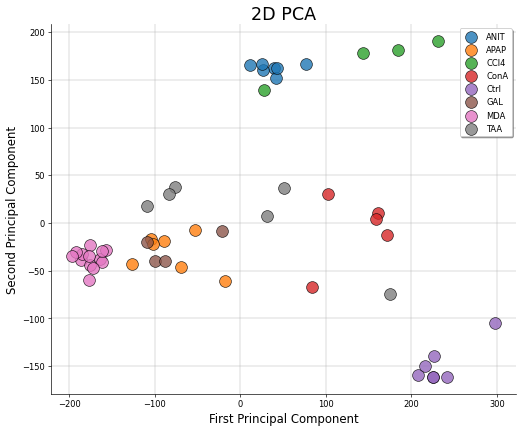

In [3]:
#%% load data
df_mix = pd.read_csv(Base_dir+'/data/mix_processed.csv',index_col=0)
remove_list=["CIV_7","CIV_8","CIP_7","CIP_8"]
target_mix = df_mix.drop(columns=remove_list)
#%% normalize with Ctrl expression
ctrl_df = target_mix[['Ctrl_1', 'Ctrl_10', 'Ctrl_12', 'Ctrl_15', 'Ctrl_16', 'Ctrl_17', 'Ctrl_18', 'Ctrl_2', 'Ctrl_3', 'Ctrl_4', 'Ctrl_7', 'Ctrl_8', 'Ctrl_9']]
ctrl_m = ctrl_df.T.mean()
ctrl_v = ctrl_df.T.var()
norm_df = (((target_mix.T-ctrl_m))/np.sqrt(ctrl_v)).T # normalization 

target_names = [t.split('_')[0] for t in target_mix.columns.tolist()]
target_dic = dict(zip(list(set(target_names)), [i for i in range(len(set(target_names)))]))
targets = [target_dic.get(k) for k in target_names]

#%% PCA (2D)
norm_df = norm_df.replace([np.inf, -np.inf], np.nan)
final_df = norm_df.dropna().T

pca3 = PCA()
pca3.fit(final_df)
transformed = pca3.fit_transform(final_df)

pd.DataFrame(transformed, columns=["PC{}".format(x + 1) for x in range(len(transformed))]).head()

fig,ax = plt.subplots(figsize = (10, 8), dpi=60)

for label in np.unique(targets):
    p = ax.scatter(transformed[targets == label, 0],
                   transformed[targets == label, 1],
                   marker = 'o', s = 200, label=np.unique(target_names)[label],alpha=0.8,linewidths=0.8,edgecolor='k')

ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
plt.legend(shadow=True)
plt.title('2D PCA',fontsize = 21)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
ax.set_axisbelow(True)
ax.grid(color="#ababab",linewidth=0.5)
plt.show()

***
##### ② LM13 data
- Data for creating cell type-specific expression X for N genes across K cell types.
- We downloaded raw RNA-Seq expression datasets for 9 leukocyte subsets and 4 liver-related cell types from the Gene Expression Omnibus (GEO).
- The data were processed in the following order: log transformation, elimination of low-expressing genes, and quantile normalization.
- In this case, N=51463 and K=13
  1. Neutrophils
  2. Monocytes
  3. B cells
  4. CD8 T cells
  5. CD4 T cells
  6. NK cells
  7. Eosinophils
  8. Basophils
  9. Kupffer
  10. Hepatocytes
  11. Cholangiocytes
  12. Stellate
  13. LSEC

In [4]:
# reference
df_ref = pd.read_csv(Base_dir+'/data/ref_13types.csv',index_col=0)
df_ref

,NK_GSE114827_1,NK_GSE114827_2,NK_GSE114827_3,NK_GSE103901_1,NK_GSE103901_2,NK_GSE103901_3,NK_GSE103901_4,NK_GSE103901_5,B_GSE84878_1,B_GSE84878_2,...,LSEC_GSE120281_1,LSEC_GSE120281_2,LSEC_GSE120281_3,LSEC_GSE120282_1,LSEC_GSE120282_2,LSEC_GSE120282_3,LSEC_GSE135789_1,LSEC_GSE135789_2,LSEC_GSE135789_3,LSEC_GSE135789_4
mgi,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,11.216826,23.474148,0.987152,15.364877,31.139537,22.703545,20.156833,29.162144,0.612939,1.192251,...,12.298976,76.916281,41.270084,28.856090,6.702005,17.255757,28.317989,33.905790,4.296730,7.443342
0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,2.532700,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610009B22Rik,3801.734228,3838.271735,590.980263,1673.625997,1265.782913,660.394232,596.272184,641.598858,424.297827,489.444747,...,139.429684,64.162805,103.716779,113.015607,106.637527,214.289784,849.609673,1282.319472,852.775792,1173.783288
0610009E02Rik,38.492335,26.822363,9.531486,31.225440,5.380941,25.955692,27.520060,22.481986,30.104838,24.581738,...,32.408879,48.411034,51.805864,12.867085,22.047564,14.648481,9.014010,34.387327,18.025384,25.093965
0610009L18Rik,260.189214,144.910984,115.846603,639.627003,664.538873,333.376854,357.646002,390.423509,71.599094,72.398348,...,27.368506,19.615761,17.567439,17.163154,11.899047,23.225588,145.807093,189.147226,166.073179,112.401889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s41,0.000000,0.000000,0.000000,0.000000,56.173842,0.000000,126.690794,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,174.691917,0.000000,0.000000,0.000000,0.000000,0.000000
n-R5s65,0.000000,0.000000,0.000000,0.000000,58.420842,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,259.503070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n-R5s7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.690794,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Note that, this is not cell type-*specific* matrix yet. You need to detect differentially expressed gene and create the reference.

You can see the detailed process at '2_simple_deconv_with_LM13.ipynb'

***
##### ③ True proportion
- Cell type proportion matrix P for K cell types.
- The proportion of various immune cells in the animals prepared in ① were measured by flow cytometry.
- Cell types in the row and samples are in the columns.

In [5]:
p_df = pd.read_csv('C:/github/LiverDeconv/Data/facs_true_population.csv',index_col=0)
p_df

,Ctrl_1,Ctrl_2,Ctrl_3,Ctrl_4,Ctrl_7,Ctrl_8,Ctrl_9,Ctrl_10,Ctrl_12,Ctrl_15,...,GAL_4,GAL_7,GAL_8,CCl4_1,CCl4_5,CCl4_6,CCl4_8,CCl4_10,CCl4_11,CCl4_12
abT,0.144218,0.354034,0.128803,0.324972,0.220206,0.237484,0.255721,0.237037,0.206329,0.324946,...,0.209323,0.170507,0.159999,0.062073,0.083305,0.102858,0.069978,0.117509,0.098660,0.126296
gdT,0.015701,0.044586,0.017606,0.031974,0.077327,0.081104,0.072014,0.065368,0.080969,0.017127,...,0.086265,0.105757,0.100388,0.040561,0.020459,0.046222,0.036410,0.014233,0.025717,0.014465
NKT,0.207992,0.356555,0.173388,0.291621,0.057071,0.056809,0.068943,0.045804,0.049266,0.013572,...,0.027121,0.035595,0.050206,0.011263,0.009067,0.018162,0.014175,0.006066,0.004712,0.005096
NK,0.073829,0.156051,0.084659,0.148015,0.069933,0.064143,0.093055,0.071661,0.062468,0.134838,...,0.077900,0.084268,0.099906,0.060576,0.040599,0.064700,0.045799,0.126684,0.079953,0.114220
Monocyte,0.042073,0.037323,0.033776,0.038917,0.070734,0.088048,0.081692,0.078317,0.081349,0.087028,...,0.168436,0.225883,0.207007,0.244281,0.215106,0.204040,0.195473,0.232481,0.266219,0.269011
Neutrophil,0.007093,0.014520,0.008112,0.012331,0.023041,0.024363,0.023031,0.021430,0.024332,0.026191,...,0.049688,0.053040,0.058662,0.112468,0.182593,0.104072,0.103211,0.055559,0.103039,0.075801
Kupffer,0.007140,0.011332,0.013643,0.029472,0.105503,0.079319,0.055698,0.116123,0.109195,0.007924,...,0.020971,0.011161,0.022467,0.097516,0.032060,0.054342,0.080614,0.038348,0.029354,0.037406
Eosinophil,0.026264,0.034089,0.034685,0.023204,0.022290,0.031299,0.031347,0.031893,0.031820,0.036573,...,0.053388,0.067346,0.069592,0.133552,0.107666,0.086624,0.118155,0.111389,0.115242,0.090145
Mono_Mac,0.010014,0.013822,0.007104,0.010786,0.011395,0.011079,0.014566,0.008946,0.009895,0.002871,...,0.010010,0.012379,0.014415,0.013371,0.011503,0.009644,0.014263,0.002166,0.005340,0.003438


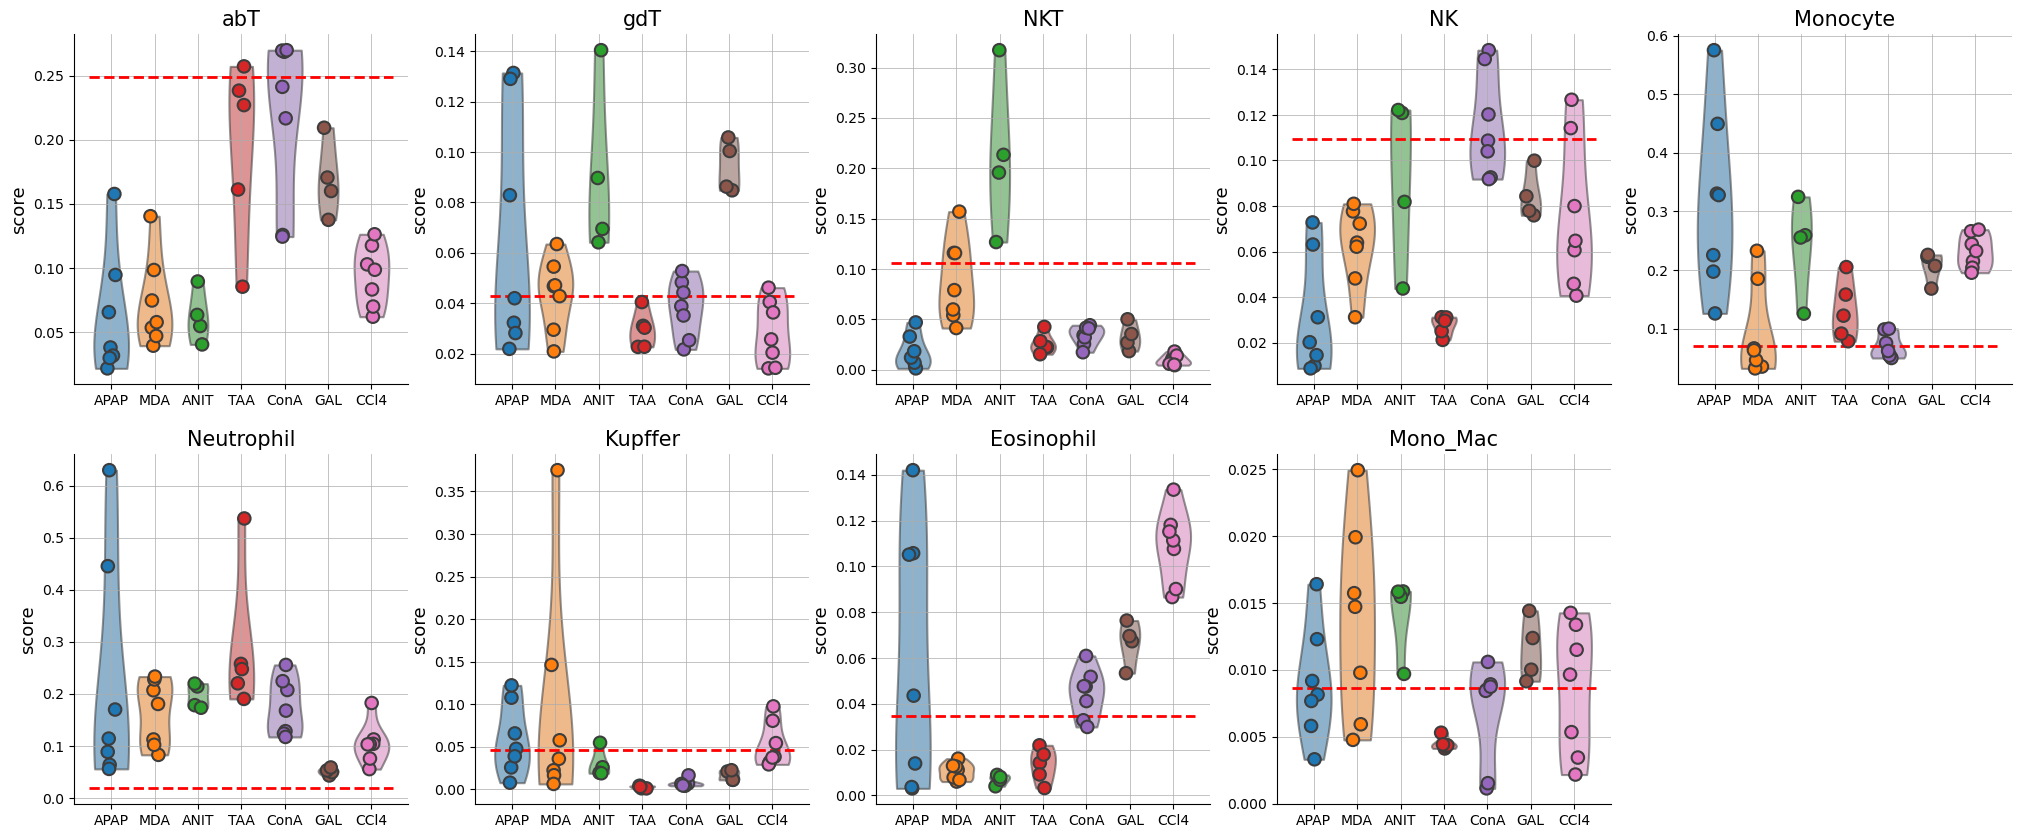

In [6]:
remove_list = ['CIV_1','CIV_4','CIV_7','CIV_8','CIP_1','CIP_2','CIP_7','CIP_8']
common_list = list(set(p_df.columns.tolist()) & set(remove_list))
removed_df = p_df.drop(columns=common_list) # remove

p4d.plot_violin(target_df=removed_df.T,sep="_",sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4"],
                target_cell=[],ctrl="Ctrl",
                x_doc="",y_doc="score",row_n=2,col_n=5)

***
##### ④ Additional: Blood Biochemistry Values (blood_biochemistry_value.csv)
- ALT (alanine transaminase): Enzyme found mostly in liver, and high levels of SLT may be a sign of a liver injury.
- AST (aspartate aminotransferase): Enzyme found moustly in heart muscle, skeletal muscle, and liver.
- TBIL (total bilirubin): When there is an abnormality in the liver, gall bladder, or biliary tract, bilirubin increases in the blood, resulting in jaundice.

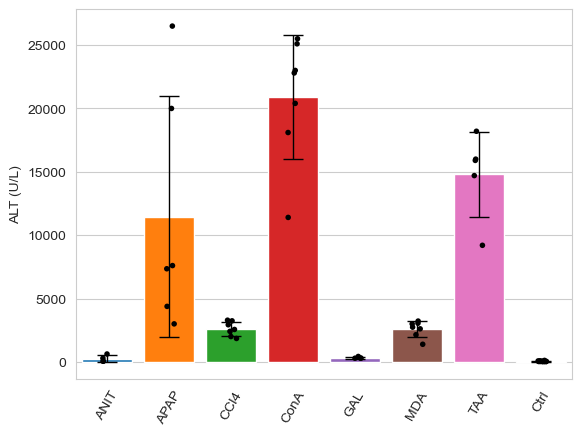

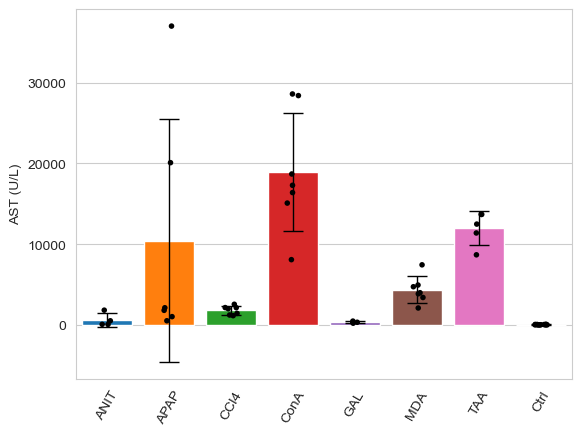

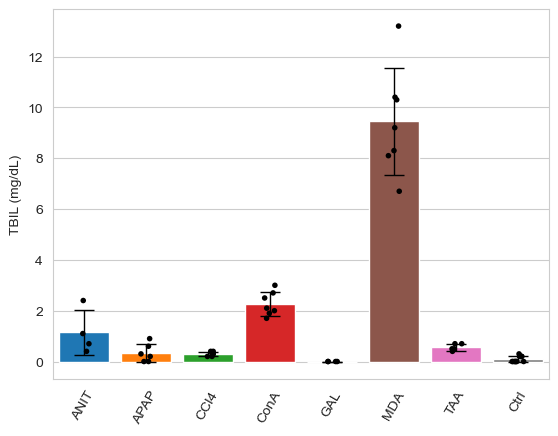

In [7]:
#%%
def plot_multi(data=[[11,50,37,202,7],[47,19,195,117,74],[136,69,33,47],[100,12,25,139,89]],names = ["+PBS","+Nefopam","+Ketoprofen","+Cefotaxime"],value="ALT (U/I)",title="",dpi=100,log_scale=False):
    tmp_color = sns.color_palette("tab10")
    sns.set_style('whitegrid')
        
    fig,ax = plt.subplots(dpi=dpi)
    sns.color_palette("tab10")
    df = pd.DataFrame()
    for i in range(len(data)):
        tmp_df = pd.DataFrame({names[i]:data[i]})
        df = pd.concat([df,tmp_df],axis=1)
    error_bar_set = dict(lw=1,capthick=1,capsize=50/(len(data)-1))
    if log_scale:    
        ax.set_yscale('log')
    ax.bar([i for i in range(len(data))],df.mean(),yerr=df.std(),tick_label=df.columns,error_kw=error_bar_set,color=tmp_color)
    # jitter plot
    df_melt = pd.melt(df)
    sns.stripplot(x='variable', y='value', size=4, data=df_melt, jitter=True, color='black', ax = ax)
        
    ax.set_xlabel('')
    ax.set_ylabel(value)
    plt.title(title)
    plt.xticks(rotation=60)
    plt.show()

#%% blood biochemistry values by treatment group
df = pd.read_csv(Base_dir + '/Data/mix_processed.csv',index_col=0)
samples = df.columns.tolist()

bb_df = pd.read_csv(Base_dir+'/Data/info/blood_biochemistry_values.csv',index_col=0)

# ALT
comp_list = ['ANIT', 'APAP', 'CCl4', 'ConA', 'GAL', 'MDA', 'TAA', 'Ctrl']
bb_values = []
for comp in comp_list:
    tmp_df = bb_df[bb_df['Treatment']==comp]
    bb_values.append(tmp_df['ALT'].tolist())
plot_multi(data=bb_values,names=comp_list,value="ALT (U/L)",log_scale=False)

# AST
comp_list = ['ANIT', 'APAP', 'CCl4', 'ConA', 'GAL', 'MDA', 'TAA', 'Ctrl']
bb_values = []
for comp in comp_list:
    tmp_df = bb_df[bb_df['Treatment']==comp]
    bb_values.append(tmp_df['AST'].tolist())
plot_multi(data=bb_values,names=comp_list,value="AST (U/L)",log_scale=False)

# TBIL
comp_list = ['ANIT', 'APAP', 'CCl4', 'ConA', 'GAL', 'MDA', 'TAA', 'Ctrl']
bb_values = []
for comp in comp_list:
    tmp_df = bb_df[bb_df['Treatment']==comp]
    bb_values.append(tmp_df['TBIL'].tolist())
plot_multi(data=bb_values,names=comp_list,value="TBIL (mg/dL)",log_scale=False)